<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The first set of problems deal with the Cora dataset[6], which is citation graph of scientific
papers. The nodes (papers) have features given by sparse bag-of-words vector that cor-
respond to 1433 keywords. There are seven categories of papers based on a classification
of the keywords. Out of the 2708 nodes 140 are labeled in the standard training set,
20 in each class. The dataset can be found: https://github.com/kimiyoung/planetoid or
through PyG.
You are welcome to use the Colab Notebook on node classification on the Cora dataset
provided in the PyTorch Geometric documentation. Either modify and run directly in
Google Colab or reuse relevant parts of the code in your own Jupyter notebook or other
environment.


1.   From the Planetoid Cora dataset, extract the number of nodes that are in the training set, validation set, and test set. Discuss briefly the implications for super-
vised versus semi-supervised learning.
2.   Train both a standard dense network using supervised learning and a network
using the convolution from equation 1 using semi-supervised learning.
3. Use t-SNE to visualize the results.
All of this is essentially provided in the Colab notebook referred to above. You are also
welcome to try out varying the depth and width of the network to improve the accuracy.









In [1]:
!pip install torch_geometric
!pip install pyvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch_geometric.utils as utils
import numpy as np
import networkx as nx
from torch_geometric.nn import global_mean_pool, GraphConv, GATConv, GCNConv, NNConv

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Aquire the dataset
dataset1 = Planetoid(root='/tmp/Cora', name='Cora')

data1 = dataset1[0].to(device)

Processing...
Done!


In [5]:
# Nodes for training, validation, and test sets
train_mask = data1.train_mask.sum().item()
val_mask = data1.val_mask.sum().item()
test_mask = data1.test_mask.sum().item()

print(f'Training set nodes: {train_mask}')
print(f'Validation set nodes: {val_mask}')
print(f'Test set nodes: {test_mask}')

Training set nodes: 140
Validation set nodes: 500
Test set nodes: 1000


# Discussion (supervised vs semisupervised learning)

With only 140 labeled nodes in the training set, we need to use the unlabeled data in a clever way to improve how much the model can learn. This is common in reality as it is difficult or costly to label data. In semi-supervised learning the model uses the graph structure to propagate the influence of labeled nodes onto theeir unlabeled neighbours. Perhaps some data-augmentation can be used by either messing with the graphs or simply creating new graphs that are slightly perturbed versions of the already labeled ones.



In [36]:
# Dense NN
# Dense Neural Network
class DenseNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DenseNN, self).__init__()
        self.Linear1 = nn.Linear(input_dim, hidden_dim)
        self.Linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.Linear3 = nn.Linear(hidden_dim, output_dim)
        self.ReLU = nn.ReLU()

    def forward(self, data):
        x = data.x
        x = self.ReLU(self.Linear1(x))
        x = self.ReLU(self.Linear2(x))
        x = self.Linear3(x)
        return F.log_softmax(x, dim=1)

# Graph Convolutional Network
class ConvNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ConvNet, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.ReLU = nn.ReLU()

    def forward(self, data):
        x, edgeIndex = data.x, data.edge_index
        x = self.ReLU(self.conv1(x, edgeIndex))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.conv2(x, edgeIndex)
        return F.log_softmax(x, dim=1)

input_dim = dataset1.num_node_features
hidden_dim = input_dim
output_dim = dataset1.num_classes

dense_model = DenseNN(input_dim, hidden_dim, output_dim).to(device)
gcn_model = ConvNet(input_dim, hidden_dim, output_dim).to(device)

In [37]:
optimizer_dense = optim.Adam(dense_model.parameters(), lr=0.01)
optimizer_gcn = optim.Adam(gcn_model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

Epoch 1: Trainloss: 1.9462761878967285, ValidationLoss: 1.794616460800171
Epoch 6: Trainloss: 0.0066070654429495335, ValidationLoss: 4.676307678222656
Epoch 11: Trainloss: 4.325528095705522e-07, ValidationLoss: 11.961418151855469
Epoch 16: Trainloss: 1.7029897492193413e-09, ValidationLoss: 19.440078735351562
Epoch 1: Trainloss: 1.9477944374084473, ValidationLoss: 1.343661904335022
Epoch 6: Trainloss: 0.003848129417747259, ValidationLoss: 1.0956401824951172
Epoch 11: Trainloss: 0.00014856827328912914, ValidationLoss: 1.6932590007781982
Epoch 16: Trainloss: 1.8306377569388133e-06, ValidationLoss: 2.0888571739196777


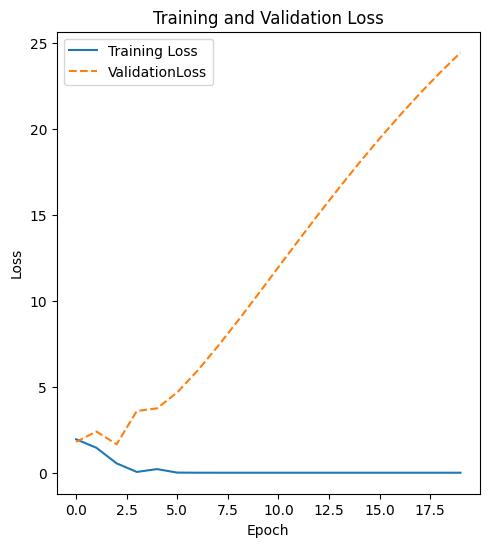

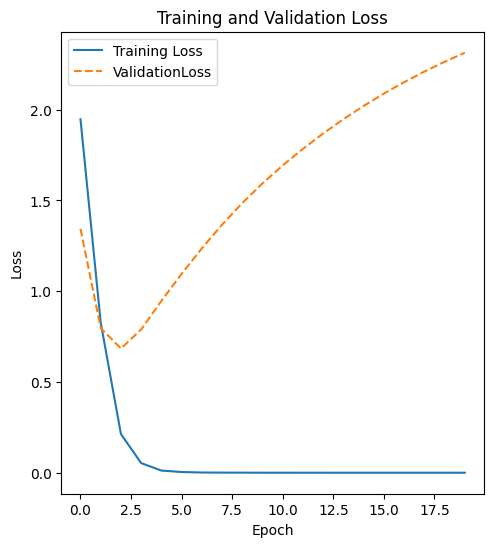

In [38]:
def train_and_validate(model, optimizer, criterion, data, train_mask, val_mask, num_epochs=100, model_name='model'):
    model.to(device)
    data.to(device)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[train_mask], data.y[train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[val_mask], data.y[val_mask])
            val_losses.append(val_loss.item())

            # Check for improvement and save the model if better
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'{model_name}_best.pth')
                #print(f'Epoch {epoch+1}: New best validation loss: {best_val_loss}')
            if (epoch % 5 == 0):
              print(f'Epoch {epoch+1}: Trainloss: {train_losses[-1]}, ValidationLoss: {val_losses[-1]}')

    return train_losses, val_losses

# Training and validation
num_epochs = 20
train_losses_dense, val_losses_dense = train_and_validate(dense_model, optimizer_dense, criterion, data1, data1.train_mask, data1.val_mask, num_epochs, 'dense_nn')
train_losses_gcn, val_losses_gcn = train_and_validate(gcn_model, optimizer_gcn, criterion, data1, data1.train_mask, data1.val_mask, num_epochs, 'gcn_model')

# Plotting results
def plot_training(train_losses, val_losses, metric):
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label='Training ' + metric)
  plt.plot(val_losses, label='Validation' + metric, linestyle='--')
  plt.title('Training and Validation ' + metric)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot_training(train_losses_dense, val_losses_dense, "Loss")
plot_training(train_losses_gcn, val_losses_gcn, "Loss")




In [31]:
dense_model.load_state_dict(torch.load("dense_nn_best.pth"))
gcn_model.load_state_dict(torch.load("gcn_model_best.pth"))

<All keys matched successfully>

In [32]:
def TSNE_visualize(model, data):
  model.eval()
  with torch.no_grad():
      out = model(data)  # Get the model outputs

  # Use t-SNE to reduce dimensionality
  tsne = TSNE(n_components=2, random_state=42)
  reduced = tsne.fit_transform(out.cpu().detach().numpy())  # Make sure the data is on CPU

  # Plot t-SNE
  plt.figure(figsize=(8, 8))
  scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=data.y.cpu().numpy(), cmap='viridis', alpha=0.6)
  plt.colorbar(scatter)
  plt.title('t-SNE Visualization of Node Embeddings')
  plt.xlabel('Component 1')
  plt.ylabel('Component 2')
  plt.show()

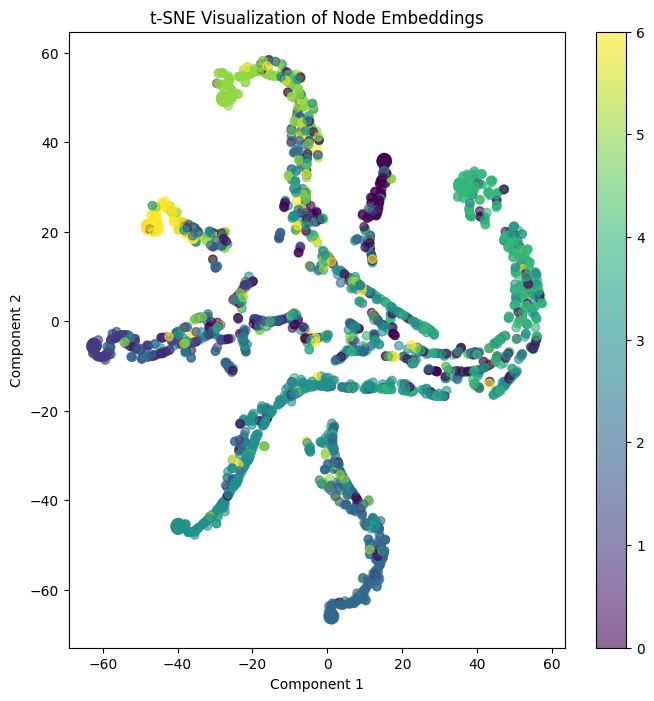

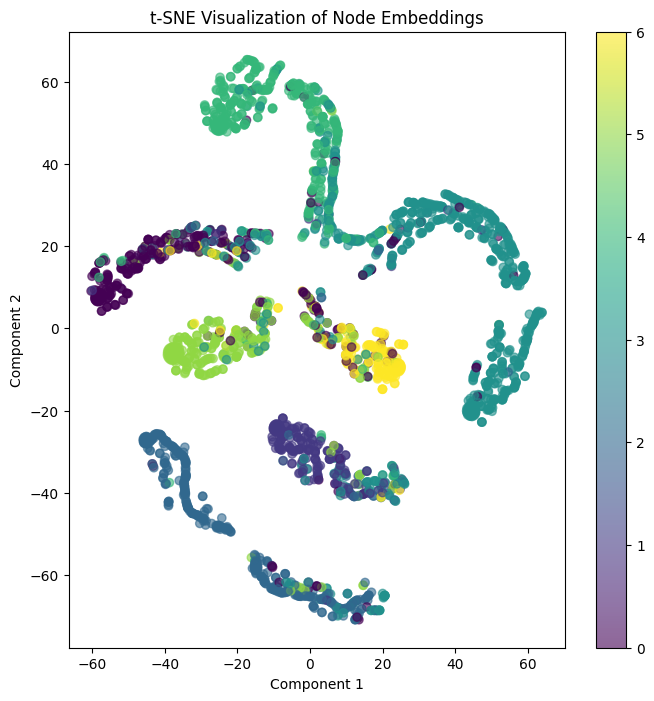

In [15]:
TSNE_visualize(dense_model, data1)
TSNE_visualize(gcn_model, data1)

# **PART 2**

**Train a graph neural network for graph classification using the dataset provided on Google Drive. This notebook provides basic code for loading the data and relevant modules and gives some basic information about its structure. Rather than downloading and uploading the dataset to your own Google Drive, it is recommended to create a shortcut of the shared file to your Drive.**
- **Divide the dataset 95/5 into training set and test set.**
- **Design a graph neural network with the objective to optimize the accuracy on the test set. You should be able to get a test accuracy of at least 95%, possibly up to 98%.**
- **Plot training and test accuracy over at least 10 epochs of training.**
- **Be ready to discuss your code and the components of your network.**


In [16]:
# Get the data from Google Drive
from google.colab import drive
drive.mount('/content/drive')
dataset = torch.load('/content/drive/My Drive/Skola/Avancerade NN/HWA/graph_data_decoding_2024.pt')

Mounted at /content/drive


### Investigating the data a bit

In [17]:
print(f'Number of graphs in the dataset: {len(dataset)}')

print(f'#########################################')
print(f"Let's look at a specific graph! Lets pick graph nr: 7.")
ex_data = dataset[7]
print()
print(f' Print the data: {ex_data}')
print()
print(f'Number of nodes: {ex_data.num_nodes}')
print(f'Number of edges: {ex_data.num_edges}')
print(f'Average node degree: {ex_data.num_edges / ex_data.num_nodes:.2f}')
print(f'Has isolated nodes: {ex_data.has_isolated_nodes()}')
print(f'Has self-loops: {ex_data.has_self_loops()}')
print(f'Is undirected: {ex_data.is_undirected()}')
print(f'Number of node features: {ex_data.num_node_features}')

Number of graphs in the dataset: 1000000
#########################################
Let's look at a specific graph! Lets pick graph nr: 7.

 Print the data: Data(x=[8, 4], edge_index=[2, 52], edge_attr=[52, 1], y=[1, 2])

Number of nodes: 8
Number of edges: 52
Average node degree: 6.50
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Number of node features: 4


In [18]:
label = ex_data.y
print(label)

label_X = label[:,0]
label_Z = label[:,1]
print(label_X, label_Z)

tensor([[0., 0.]])
tensor([0.]) tensor([0.])


In [19]:
edge_index = ex_data.edge_index.t()
edge_index = edge_index.numpy()
feature = ex_data.x.numpy()
edge = ex_data.edge_attr.numpy()
print(edge_index)
print(edge)
print(feature)

[[0 1]
 [0 2]
 [0 3]
 [0 4]
 [0 5]
 [0 6]
 [0 7]
 [1 0]
 [1 2]
 [1 3]
 [1 4]
 [1 5]
 [1 6]
 [2 0]
 [2 1]
 [2 3]
 [2 5]
 [2 6]
 [2 7]
 [3 0]
 [3 1]
 [3 2]
 [3 4]
 [3 5]
 [3 6]
 [3 7]
 [4 0]
 [4 1]
 [4 3]
 [4 5]
 [4 6]
 [4 7]
 [5 0]
 [5 1]
 [5 2]
 [5 3]
 [5 4]
 [5 6]
 [5 7]
 [6 0]
 [6 1]
 [6 2]
 [6 3]
 [6 4]
 [6 5]
 [6 7]
 [7 0]
 [7 2]
 [7 3]
 [7 4]
 [7 5]
 [7 6]]
[[1.        ]
 [1.        ]
 [1.        ]
 [0.0625    ]
 [0.11111111]
 [0.11111111]
 [0.0625    ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.11111111]
 [0.25      ]
 [0.11111111]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.11111111]
 [0.25      ]
 [0.11111111]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.11111111]
 [0.25      ]
 [0.25      ]
 [0.11111111]
 [0.0625    ]
 [0.11111111]
 [0.11111111]
 [1.        ]
 [0.11111111]
 [0.0625    ]
 [0.11111111]
 [0.25      ]
 [0.11111111]
 [0.25      ]
 [1.        ]
 [0.25      ]
 [0.11111111]
 [0.11111111]
 [0.11111111]
 [0.25      ]
 [0.25      ]
 [0.11111111]
 [0.25      ]
 [1. 

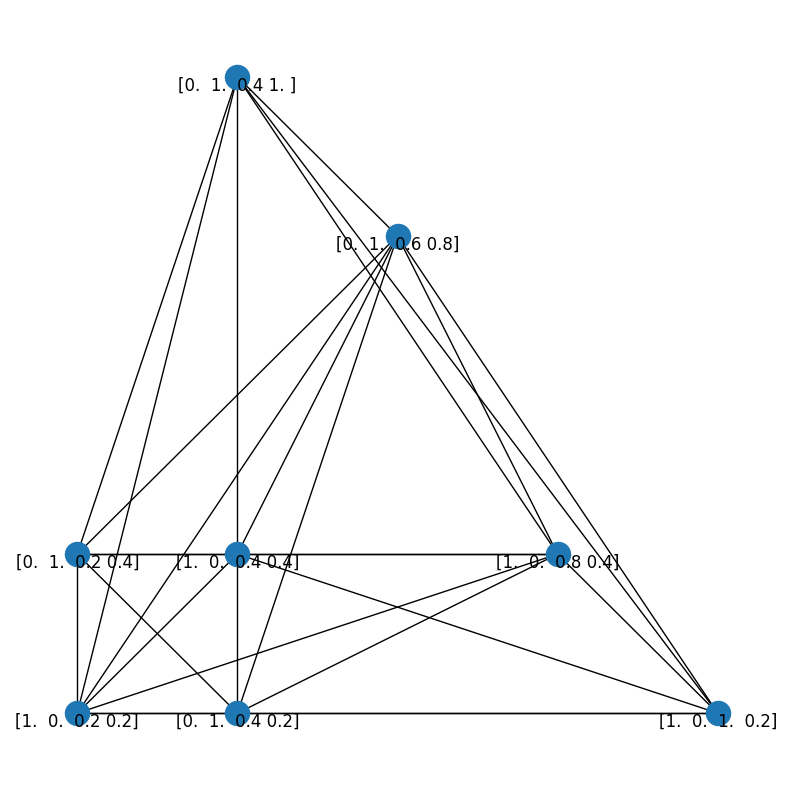

In [20]:
def plot_graph(graph):
  g = utils.to_networkx(graph, to_undirected=True)
  positions = {}
  label_positions = {}
  node_labels = {}
  edge_labels={}
  x = graph.x
  for i in range(x.shape[0]):
      positions[i] = np.array([x[i, 2], x[i, 3]])
      label_positions[i] = np.array([x[i, 2], x[i, 3]])
      node_labels[i] = np.array([x[i, 0], x[i, 1], x[i, 2], x[i, 3]])
  for i in range(edge_index.shape[0]):
      edge_labels[(edge_index[i,0],edge_index[i,1])]=edge[i]

  fig, ax = plt.subplots(figsize = (10, 10))
  nx.draw_networkx(g, ax=ax, pos = positions, labels = node_labels, with_labels = False)
  nx.draw_networkx_labels(g, ax=ax, pos = label_positions, labels = node_labels, verticalalignment= 'top')
  ax.axis('off')

plot_graph(ex_data)

# **Let's build the network**

In [21]:
# Assuming dataset is a PyTorch Dataset
num_samples = len(dataset)
num_train = int(0.95 * num_samples)
num_val = int(0.05 * num_samples)

# Generate shuffled indices
indices = torch.randperm(num_samples)

# Split indices
train_indices = indices[:num_train]
val_indices = indices[num_train:num_train + num_val]


# Create data subsets
train_data = Subset(dataset, train_indices)
val_data = Subset(dataset, val_indices)


# Data loaders
generator = torch.Generator().manual_seed(42)  # For reproducibility
train_loader = DataLoader(train_data, batch_size=100, shuffle=True, generator=generator)
val_loader = DataLoader(val_data, batch_size=100, shuffle=True, generator=generator)

# Print the number of graphs in each dataset
print(f'Number of graphs in training data: {len(train_data)} and validation data: {len(val_data)}')

Number of graphs in training data: 950000 and validation data: 50000


In [24]:
class GNN(nn.Module):
    def __init__(self):
        super().__init__()

        node_feature_size = 4
        edge_feature_size = 1
        self.convs = nn.ModuleList()
        self.edge_mlps = nn.ModuleList()
        self.bns = nn.ModuleList()  # Batch normalization layers

        layer_sizes = [node_feature_size, 32, 64, 128]

        for i in range(len(layer_sizes) - 1):
            in_channels = layer_sizes[i]
            out_channels = layer_sizes[i+1]
            mlp = nn.Sequential(
                nn.Linear(edge_feature_size, 16),
                nn.ReLU(),
                nn.Linear(16, in_channels * out_channels)
            )
            self.edge_mlps.append(mlp)
            self.convs.append(NNConv(in_channels, out_channels, nn=mlp))
            self.bns.append(nn.BatchNorm1d(out_channels))  # Adding batch normalization

        # Linear layers for classification
        self.xdense1 = nn.Linear(128, 64)
        self.xdense2 = nn.Linear(64, 2)

    def forward(self, x, edge_index, edge_attr, batch):
        for conv, bn in zip(self.convs, self.bns):  # Apply convolutions and batch normalization
            x = conv(x, edge_index, edge_attr)
            x = bn(x)  # Apply batch normalization
            x = F.relu(x)  # Using ReLU activation function

        x = global_mean_pool(x, batch)  # Global mean pooling
        x = F.dropout(x, p=0.1, training=self.training)
        x = F.relu(self.xdense1(x))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.xdense2(x)
        return x

In [25]:
import torch
from tqdm import tqdm

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, n_epochs, device='cpu'):
    # This dictionary will store the losses and accuracies for each epoch
    metrics = {
        'train_loss': [],
        'val_loss': [],
        'train_accuracy': [],
        'val_accuracy': []
    }

    for epoch in range(n_epochs):  # Loop over the number of epochs
        model.train()
        total_train_correct = 0
        total_train_labels = 0
        total_train_loss = 0

        for data in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
            data.x = data.x.to(device)
            data.edge_index = data.edge_index.to(device)
            data.edge_attr = data.edge_attr.to(device)
            data.batch = data.batch.to(device)
            data.y = data.y.to(device)

            optimizer.zero_grad()
            out = model(data.x, data.edge_index, data.edge_attr, data.batch)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * data.y.size(0)
            prediction = torch.sigmoid(out).round().int()
            correct = (prediction == data.y).all(dim=1)
            total_train_correct += correct.sum().item()
            total_train_labels += data.y.size(0)

        train_accuracy = total_train_correct / total_train_labels
        train_loss = total_train_loss / total_train_labels
        metrics['train_accuracy'].append(train_accuracy)
        metrics['train_loss'].append(train_loss)

        # Test against the evaluation data
        model.eval()
        total_val_correct = 0
        total_val_labels = 0
        total_val_loss = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}"):
                data.x = data.x.to(device)
                data.edge_index = data.edge_index.to(device)
                data.edge_attr = data.edge_attr.to(device)
                data.batch = data.batch.to(device)
                data.y = data.y.to(device)

                out = model(data.x, data.edge_index, data.edge_attr, data.batch)
                loss = criterion(out, data.y)
                total_val_loss += loss.item() * data.y.size(0)
                prediction = torch.sigmoid(out).round().int()
                correct = (prediction == data.y).all(dim=1)
                total_val_correct += correct.sum().item()
                total_val_labels += data.y.size(0)

        val_accuracy = total_val_correct / total_val_labels
        val_loss = total_val_loss / total_val_labels

        print(f'Traning Loss: {train_loss}, Validation Loss: {val_loss}')
        print(f'Traning Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}')

        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_loss'].append(val_loss)

    return metrics


In [26]:
modelGCN = GNN().to(device)
n_epochs = 25
learning_rate = 0.001
optimizer = torch.optim.Adam(modelGCN.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()

metrics = train_and_validate(model=modelGCN, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, n_epochs=n_epochs, device=device)



Validating Epoch 1: 100%|██████████| 500/500 [00:03<00:00, 137.29it/s]


Traning Loss: 0.07215985146949165, Validation Loss: 0.048643793041817845
Traning Accuracy: 0.9455842105263158, Validation Accuracy: 0.96364


Validating Epoch 2: 100%|██████████| 500/500 [00:03<00:00, 137.84it/s]


Traning Loss: 0.04484136545814966, Validation Loss: 0.03829609427461401
Traning Accuracy: 0.9685494736842105, Validation Accuracy: 0.97306


Validating Epoch 3: 100%|██████████| 500/500 [00:04<00:00, 120.49it/s]


Traning Loss: 0.03963332843388382, Validation Loss: 0.034407646812032906
Traning Accuracy: 0.972657894736842, Validation Accuracy: 0.975


Validating Epoch 4: 100%|██████████| 500/500 [00:05<00:00, 97.35it/s]


Traning Loss: 0.03688574060721715, Validation Loss: 0.03417767857667059
Traning Accuracy: 0.9747831578947368, Validation Accuracy: 0.97478


Validating Epoch 5: 100%|██████████| 500/500 [00:03<00:00, 136.56it/s]


Traning Loss: 0.03524031436948204, Validation Loss: 0.033495355662889775
Traning Accuracy: 0.9758157894736842, Validation Accuracy: 0.97582


Validating Epoch 6: 100%|██████████| 500/500 [00:03<00:00, 137.39it/s]


Traning Loss: 0.033981879134564415, Validation Loss: 0.0311014890470542
Traning Accuracy: 0.9767252631578948, Validation Accuracy: 0.97806


Validating Epoch 7: 100%|██████████| 500/500 [00:03<00:00, 133.32it/s]


Traning Loss: 0.03295950433511385, Validation Loss: 0.029901928755454717
Traning Accuracy: 0.9774, Validation Accuracy: 0.97892


Validating Epoch 8: 100%|██████████| 500/500 [00:04<00:00, 110.20it/s]


Traning Loss: 0.03212873178838115, Validation Loss: 0.03022234710329212
Traning Accuracy: 0.9781442105263158, Validation Accuracy: 0.97898


Validating Epoch 9: 100%|██████████| 500/500 [00:03<00:00, 138.74it/s]


Traning Loss: 0.03138776121597345, Validation Loss: 0.02955359513266012
Traning Accuracy: 0.9786747368421053, Validation Accuracy: 0.98028


Validating Epoch 10: 100%|██████████| 500/500 [00:03<00:00, 137.29it/s]


Traning Loss: 0.03083203541937186, Validation Loss: 0.02896235280809924
Traning Accuracy: 0.9790357894736842, Validation Accuracy: 0.98008


Validating Epoch 11: 100%|██████████| 500/500 [00:03<00:00, 134.90it/s]


Traning Loss: 0.030511534065388046, Validation Loss: 0.02840522615145892
Traning Accuracy: 0.9792810526315789, Validation Accuracy: 0.981


Validating Epoch 12: 100%|██████████| 500/500 [00:03<00:00, 135.41it/s]


Traning Loss: 0.02996847150529931, Validation Loss: 0.02835845917556435
Traning Accuracy: 0.9796168421052631, Validation Accuracy: 0.98058


Validating Epoch 13: 100%|██████████| 500/500 [00:03<00:00, 137.37it/s]


Traning Loss: 0.029775685910711457, Validation Loss: 0.028195174187654628
Traning Accuracy: 0.9798526315789474, Validation Accuracy: 0.98084


Validating Epoch 14: 100%|██████████| 500/500 [00:03<00:00, 138.77it/s]


Traning Loss: 0.02939916104737571, Validation Loss: 0.028208977826405315
Traning Accuracy: 0.9800105263157894, Validation Accuracy: 0.9799


Validating Epoch 15: 100%|██████████| 500/500 [00:03<00:00, 138.60it/s]


Traning Loss: 0.02906513626154169, Validation Loss: 0.028069614083506167
Traning Accuracy: 0.9805010526315789, Validation Accuracy: 0.98108


Validating Epoch 16: 100%|██████████| 500/500 [00:04<00:00, 107.03it/s]


Traning Loss: 0.028743659309430146, Validation Loss: 0.027521622602362187
Traning Accuracy: 0.9805305263157895, Validation Accuracy: 0.98132


Validating Epoch 17: 100%|██████████| 500/500 [00:04<00:00, 111.93it/s]


Traning Loss: 0.028465304658184514, Validation Loss: 0.0274180297027342
Traning Accuracy: 0.9807589473684211, Validation Accuracy: 0.981


Validating Epoch 18: 100%|██████████| 500/500 [00:03<00:00, 134.02it/s]


Traning Loss: 0.028258300118062546, Validation Loss: 0.02808158326265402
Traning Accuracy: 0.9808957894736842, Validation Accuracy: 0.9809


Validating Epoch 19: 100%|██████████| 500/500 [00:04<00:00, 121.96it/s]


Traning Loss: 0.02806976170585442, Validation Loss: 0.02745946208946407
Traning Accuracy: 0.9810947368421052, Validation Accuracy: 0.98114


Validating Epoch 20: 100%|██████████| 500/500 [00:03<00:00, 133.50it/s]


Traning Loss: 0.02788203603987533, Validation Loss: 0.02810608165897429
Traning Accuracy: 0.9811094736842105, Validation Accuracy: 0.98128


Validating Epoch 21: 100%|██████████| 500/500 [00:03<00:00, 136.35it/s]


Traning Loss: 0.02772508826272219, Validation Loss: 0.027630540555110203
Traning Accuracy: 0.9814021052631579, Validation Accuracy: 0.98144


Validating Epoch 22: 100%|██████████| 500/500 [00:03<00:00, 136.28it/s]


Traning Loss: 0.027429392887598002, Validation Loss: 0.027463351308833806
Traning Accuracy: 0.9815789473684211, Validation Accuracy: 0.98128


Validating Epoch 23: 100%|██████████| 500/500 [00:04<00:00, 115.78it/s]


Traning Loss: 0.02728750196791646, Validation Loss: 0.027358596761710943
Traning Accuracy: 0.9817021052631579, Validation Accuracy: 0.98142


Validating Epoch 24: 100%|██████████| 500/500 [00:03<00:00, 127.31it/s]


Traning Loss: 0.027185310542522195, Validation Loss: 0.027044433045666665
Traning Accuracy: 0.9817357894736842, Validation Accuracy: 0.98192


Validating Epoch 25: 100%|██████████| 500/500 [00:03<00:00, 131.36it/s]

Traning Loss: 0.027049616057683076, Validation Loss: 0.027468178347684443
Traning Accuracy: 0.9818557894736842, Validation Accuracy: 0.98144


Last Validation Accuracy: 0.98144


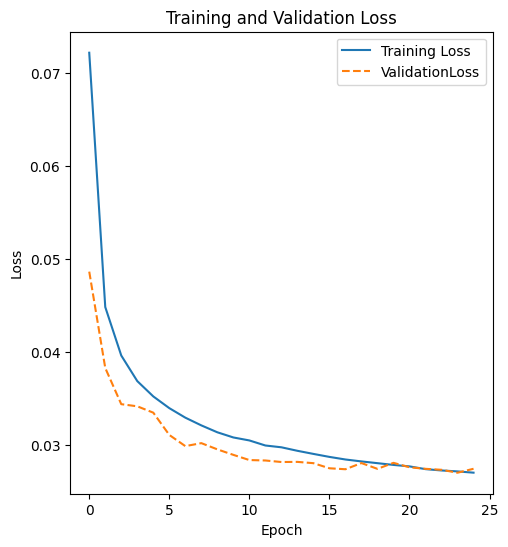

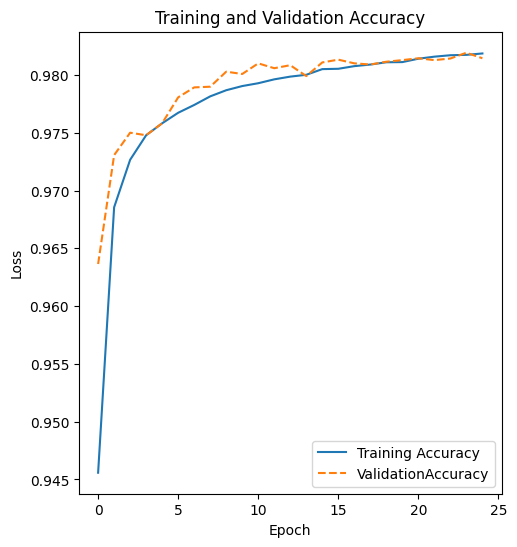

In [27]:
plot_training(metrics["train_loss"], metrics["val_loss"], "Loss")
plot_training(metrics["train_accuracy"], metrics["val_accuracy"], "Accuracy")
print(f'Last Validation Accuracy: {metrics["val_accuracy"][-1]}')